In [1]:
import requests
import io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Needs fink_utils >= 0.17.5
from fink_utils.sso.spins import estimate_sso_params
from fink_utils.sso.spins import func_hg1g2_with_spin
from fink_utils.sso.spins import func_hg1g2
from fink_utils.sso.spins import func_hg12
from fink_utils.sso.spins import func_hg

## Retrieve data from Fink with ephemerides from Miriade

In [2]:
# get data for 1465
r = requests.post(
    'https://api.fink-portal.org/api/v1/sso',
    json={
        'n_or_d': '223',
        'withEphem': True,
        'output-format': 'json'
    }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [3]:
pdf.head(2)

,index,Date,LAST,HA,Az,H,Dobs,Dhelio,VMag,SDSS:g,...,d:tracklet,d:tns,v:classification,v:lastdate,v:firstdate,v:lapse,v:constellation,sso_name,sso_number,i:magpsf_red
0,0,2.460517e+06,16:45:37.28,2.209496,218.333443,31.834855,2.970876,3.277560,15.722283,16.183983,...,,,Solar System MPC,2024-07-25 04:19:18.998,2024-07-25 04:19:18.998,0.0,Libra,Rosa,223,10.940574
1,1,2.460515e+06,16:51:33.37,2.324408,220.017095,30.995979,2.941344,3.275636,15.696919,16.158619,...,,,Solar System MPC,2024-07-23 04:33:06.002,2024-07-23 04:33:06.002,0.0,Libra,Rosa,223,10.897240


## Input vectors

It could be any data here!

In [4]:
# Reduced magnitude (observed mag - distance) & error
mag_reduced = pdf['i:magpsf_red'].values
err_mag_reduced = pdf['i:sigmapsf'].values

# Phase angle, in radians
phase = np.deg2rad(pdf['Phase'].values)

# Required for sHG1G2
ra = np.deg2rad(pdf['i:ra'].values)
dec = np.deg2rad(pdf['i:dec'].values)

# Filter band used for each observation 
# Names are arbitrary
filters = pdf['i:fid'].values

## Phase curve models

Let's use Fink built-in functions to estimate parameters for various phase curve models:
- HG, HG12, HG1G2, and sHG1G2

In [5]:
hg = estimate_sso_params(
    mag_reduced,
    err_mag_reduced,
    phase,
    filters,
    p0=[15.0, 0.15],
    bounds=([0, 0], [30, 1]),
    model='HG',
    normalise_to_V=False
)

hg12 = estimate_sso_params(
    mag_reduced,
    err_mag_reduced,
    phase,
    filters,
    p0=[15.0, 0.15],
    bounds=([0, 0], [30, 1]),
    model='HG12',
    normalise_to_V=False
)

hg1g2 = estimate_sso_params(
    mag_reduced,
    err_mag_reduced,
    phase,
    filters,
    p0=[15.0, 0.15, 0.15],
    bounds=([0, 0, 0], [30, 1, 1]),
    model='HG1G2',
    normalise_to_V=False
)

shg1g2 = estimate_sso_params(
    mag_reduced,
    err_mag_reduced,
    phase,
    filters,
    ra,
    dec,
    model='SHG1G2',
    normalise_to_V=False
)

## Residuals

Compare residuals on the phase curve (for each filter band). Reduced chi2 is quoted in the legend.

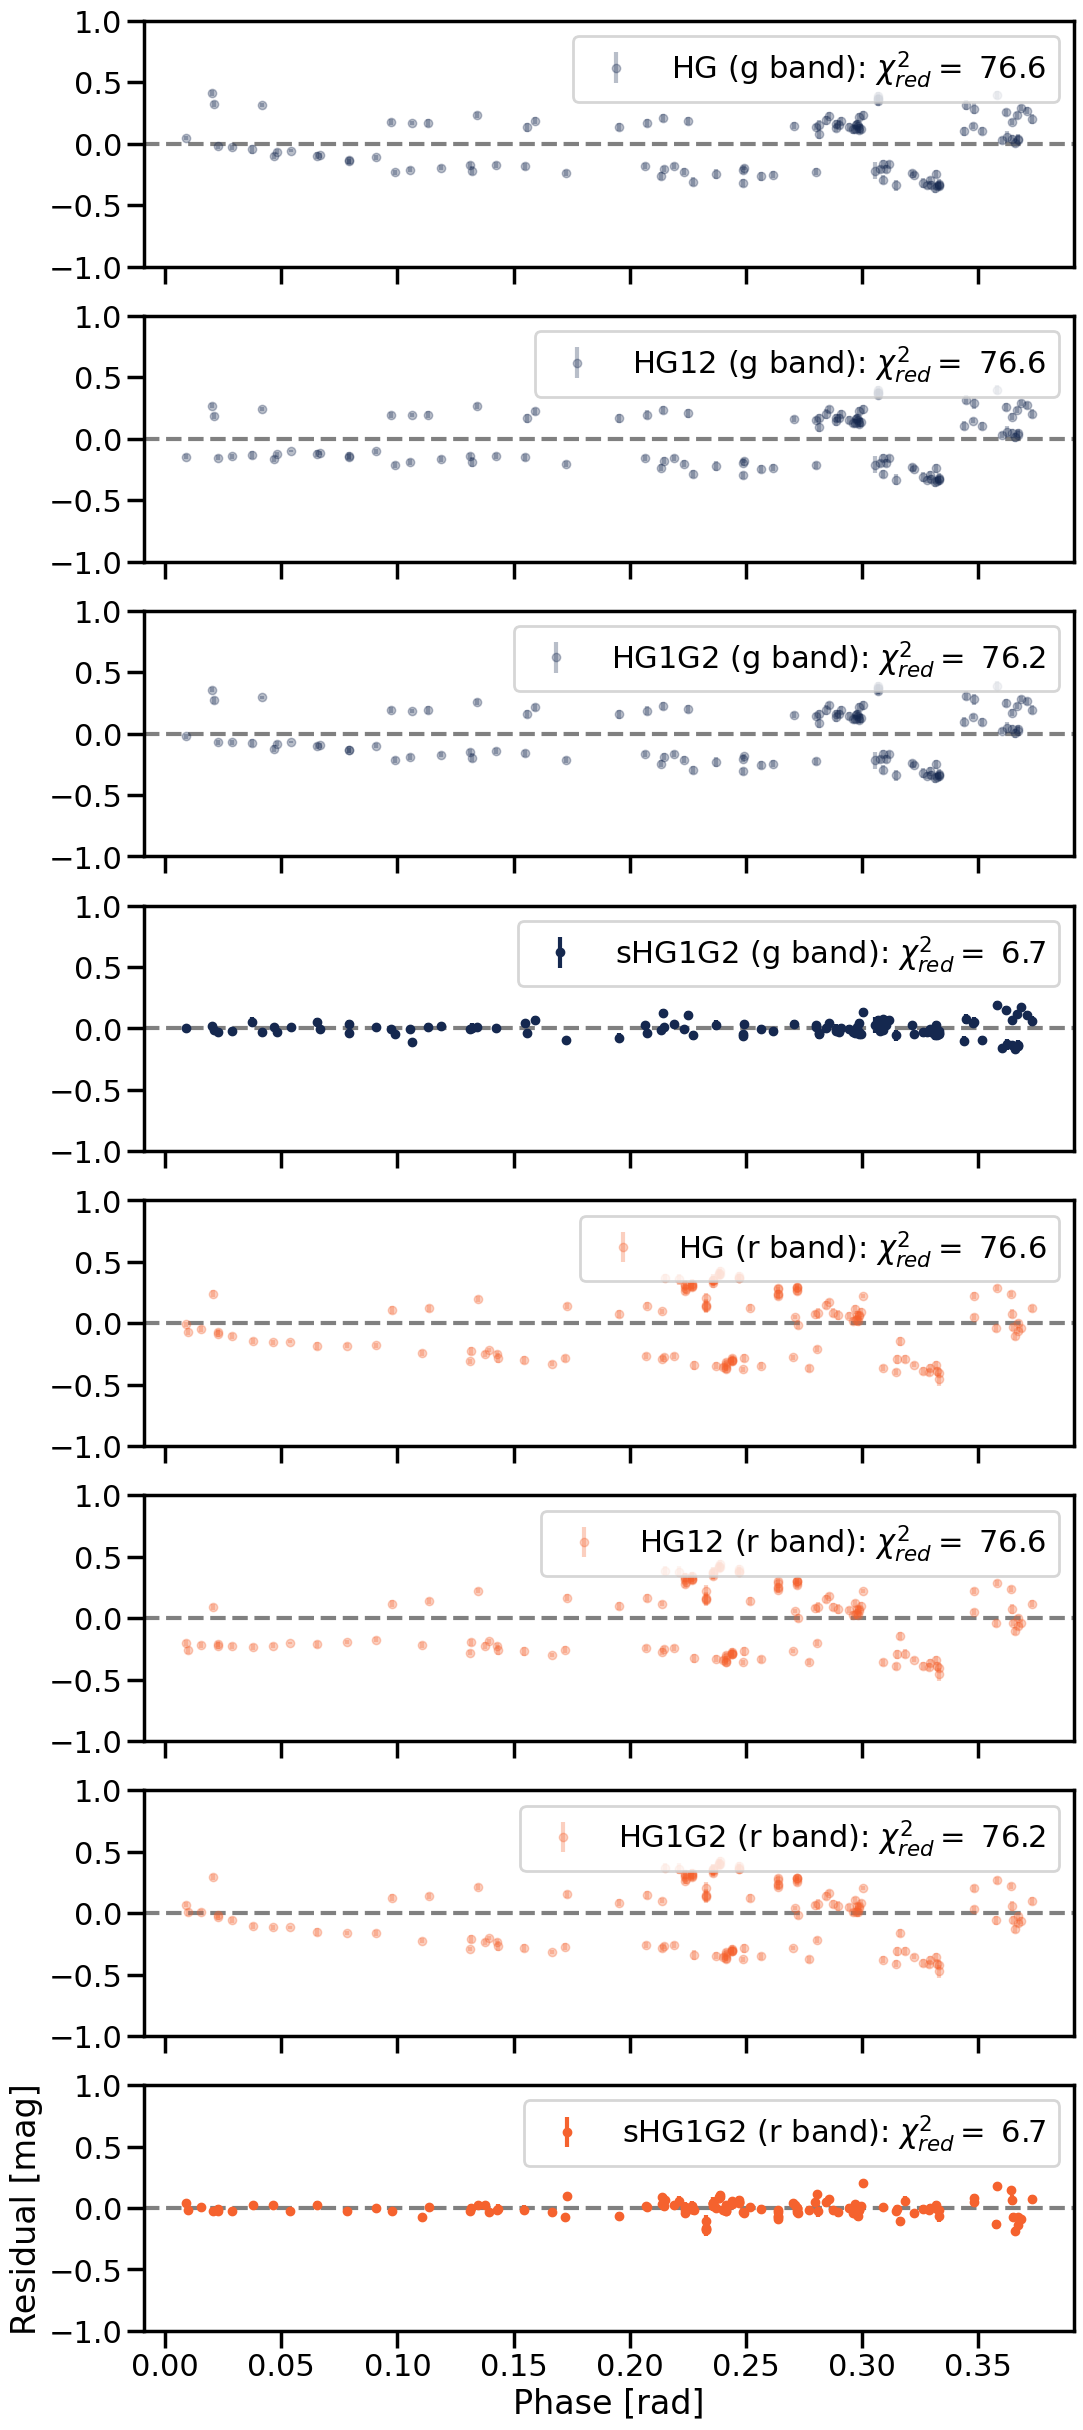

In [6]:
sns.set_context('poster')

fig, ax = plt.subplots(8, 1, figsize=(12, 30), sharex=True)
colors = ['#15284F', '#F5622E']
alphas = [0.3, 0.3, 0.3, 1.0]
model_names = ['HG', 'HG12', 'HG1G2', 'sHG1G2']
filter_names = {1: 'g', 2: 'r'}

for i, f in enumerate(np.unique(filters)[0:3]):
    cond = filters == f
    
    models = [
        func_hg(
            phase[cond], 
            hg['H_{}'.format(f)], 
            hg['G_{}'.format(f)]
        ),
        func_hg12(
            phase[cond], 
            hg12['H_{}'.format(f)], 
            hg12['G12_{}'.format(f)]
        ),
        func_hg1g2(
            phase[cond], 
            hg1g2['H_{}'.format(f)], 
            hg1g2['G1_{}'.format(f)], 
            hg1g2['G2_{}'.format(f)]
        ),
        func_hg1g2_with_spin(
            [phase[cond], ra[cond], dec[cond]], 
            shg1g2['H_{}'.format(f)], 
            shg1g2['G1_{}'.format(f)], 
            shg1g2['G2_{}'.format(f)],
            shg1g2['R'],
            np.deg2rad(shg1g2['alpha0']),
            np.deg2rad(shg1g2['delta0'])
        )
    ]
    
    chi2s = [hg['chi2red'], hg12['chi2red'], hg1g2['chi2red'], shg1g2['chi2red']]
    
    for j, model in enumerate(models):
        ydata = mag_reduced[cond] - model

        ax[i*4 + j].errorbar(
            phase[cond],
            ydata,
            yerr=err_mag_reduced[cond],
            ls = '',
            marker='.',
            color=colors[i],
            alpha=alphas[j],
            label=r'{} ({} band): $\chi^2_{{red}} =$ {:.1f}'.format(
                model_names[j], filter_names[f], chi2s[j]
            )
        )

        ax[i * 4 + j].axhline(0, ls='--', color='grey')
        ax[i * 4 + j].legend(loc='upper right')
        ax[i * 4 + j].set_ylim(-1, 1)
        if i * 4 + j == 7:
            ax[i * 4 + j].set_xlabel('Phase [rad]')
            ax[i * 4 + j].set_ylabel('Residual [mag]')
            

TODO: add SSHG1G2